# Noise2Void - 2D Example for time points between 390 and 399 - 2 Channels

Here, the volumetric images from camera CM02 have been flipped and translated. Next, the two images (CM02 and CM03) are used as two channels and denoised with N2V.

In [1]:
# We import all our dependencies.
from n2v.models import N2V
import numpy as np
from matplotlib import pyplot as plt
from tifffile import imread, imwrite
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from csbdeep.io import save_tiff_imagej_compatible
import glob
import copy

Using TensorFlow backend.


## Load the Network

In [2]:
# A previously trained model is loaded by creating a new N2V-object without providing a 'config'.  
model_name = 'n2v_2D_kellerLab_T390-399_2Channels'
basedir = 'models'
model = N2V(config=None, name=model_name, basedir=basedir)

Loading network weights from 'weights_best.h5'.


## Prediction
Here we will simply use the same data as during training and denoise it using our network.

## Load images from CM02

In [3]:
datagen = N2V_DataGenerator()

In [4]:
filenames = glob.glob("/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM02_flipped/*.tif")
filenames.sort()
imgs = [imread(img).astype('float64') for img in filenames]

print(len(imgs))
print(imgs[0].shape)

10
(70, 896, 576)


## Take only the last 35  z-slices as input from CM02

In [5]:
X_CM02=[]
for i in range(len(imgs)):
    temp=imgs[i][-35:, ...]
    X_CM02.append(temp)
print(X_CM02[5].shape)

(35, 896, 576)


## Take only the first 35 z-slices as output from CM02

In [6]:
Y_CM02=[]
for i in range(len(imgs)):
    temp=imgs[i][:35, ...]
    Y_CM02.append(temp)
print(Y_CM02[5].shape)

(35, 896, 576)


## Load images from CM03

In [7]:
filenames = glob.glob("/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM03/*.tif")
filenames.sort()
imgs = [imread(img).astype('float64') for img in filenames]

print("Typical shape:",  imgs[0].shape)
print("Typical datatype:", imgs[0].dtype)

Typical shape: (70, 896, 576)
Typical datatype: float64


## Take only the first 35 z-slices from CM03 as input

In [8]:
X_CM03=[]
for i in range(len(imgs)):
    temp=imgs[i][:35, ...]
    X_CM03.append(temp)
print(X_CM03[5].shape)

(35, 896, 576)


## Take only the last 35 z-slices from CM03 as output

In [9]:
Y_CM03=[]
for i in range(len(imgs)):
    temp=imgs[i][-35:, ...]
    Y_CM03.append(temp)
print(Y_CM03[5].shape)

(35, 896, 576)


## Combine X_CM02 and X_CM03

In [10]:
imgsX=X_CM02+X_CM03
print(len(imgsX))
print(imgsX[5].shape)

20
(35, 896, 576)


In [11]:
imgsY=Y_CM03+Y_CM02
print(len(imgsY))
print(imgsY[5].shape)

20
(35, 896, 576)


## Combine imgsX and imgsY as two channels

In [12]:
imgs=[]
for i in range(len(imgsX)):
    combined=np.empty([imgsX[0].shape[0], imgsX[0].shape[1], imgsX[0].shape[2], 2])
    combined[..., 0]=imgsX[i]
    combined[..., 1]=imgsY[i]
    imgs.append(combined)
print(len(imgs))
print(imgs[5].shape)

20
(35, 896, 576, 2)


## Visualize the images 

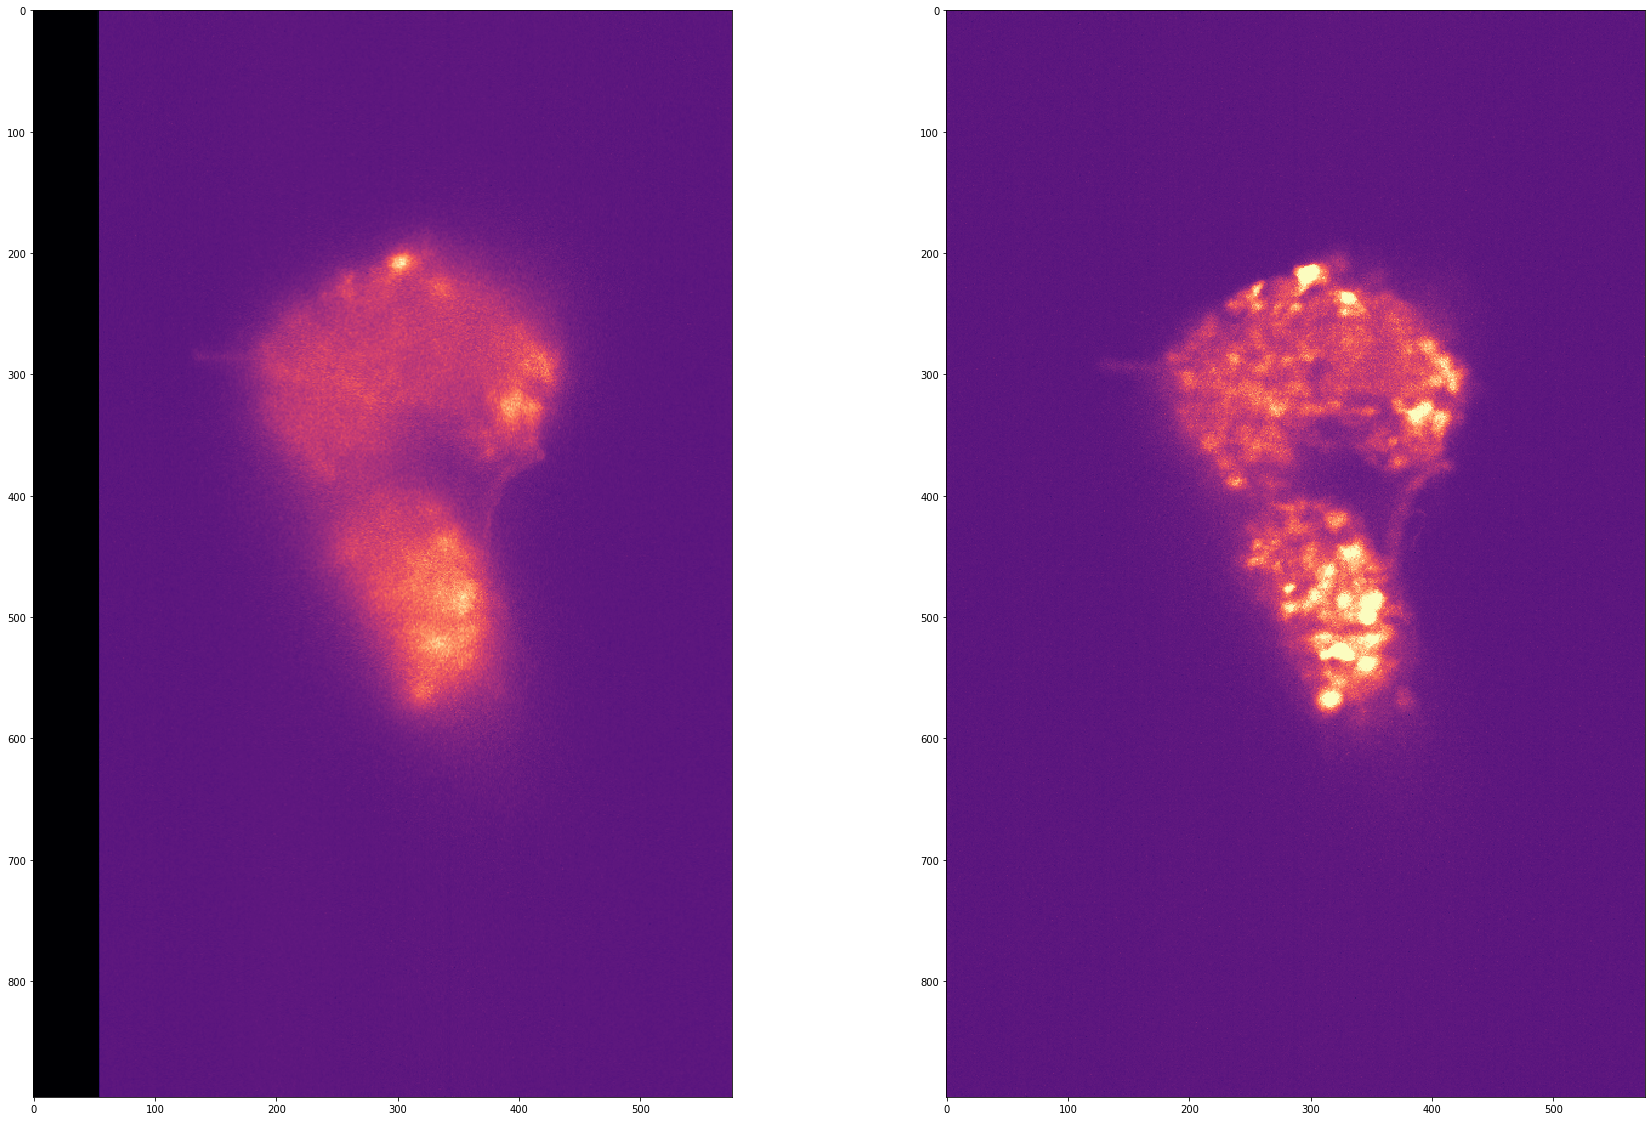

In [13]:
vmin=np.min(imgs[6][20,...,0])
vmax=np.max(imgs[6][20,..., 0])
plt.figure(figsize=(30,20))
plt.subplot(1,2,1)
plt.imshow(imgs[6][20,..., 0], cmap='magma', vmin=vmin, vmax=vmax)
plt.subplot(1,2,2)
plt.imshow(imgs[6][20,..., 1], cmap='magma', vmin=vmin, vmax=vmax)
plt.show()

## Since there is an artificial margin in the input and the output, we chop away the first and last 60 in the x dimension and in the y dimension

In [15]:
for i in range(len(imgs)):
    imgs[i]=imgs[i][:, 60:-60, 60:-60, :]
print(len(imgs))
print(imgs[5].shape)

20
(35, 776, 456, 2)


In [16]:
pred_train=copy.deepcopy(imgs)
for i in range(len(imgs)):
    for j in range(imgs[i].shape[0]):
        img=imgs[i][j, ...]
        result_image=model.predict(img, axes='YXC', n_tiles=(4,4,1))
        pred_train[i][j, ...]=result_image


100%|██████████| 16/16 [00:00<00:00, 90.27it/s]  


100%|██████████| 16/16 [00:00<00:00, 87.51it/s]  


100%|██████████| 16/16 [00:00<00:00, 100.50it/s] 


100%|██████████| 16/16 [00:00<00:00, 87.13it/s]  


100%|██████████| 16/16 [00:00<00:00, 90.22it/s]  


In [17]:
print(len(pred_train))
print(pred_train[0].shape)

20
(35, 776, 456, 2)


### Show results on training data...

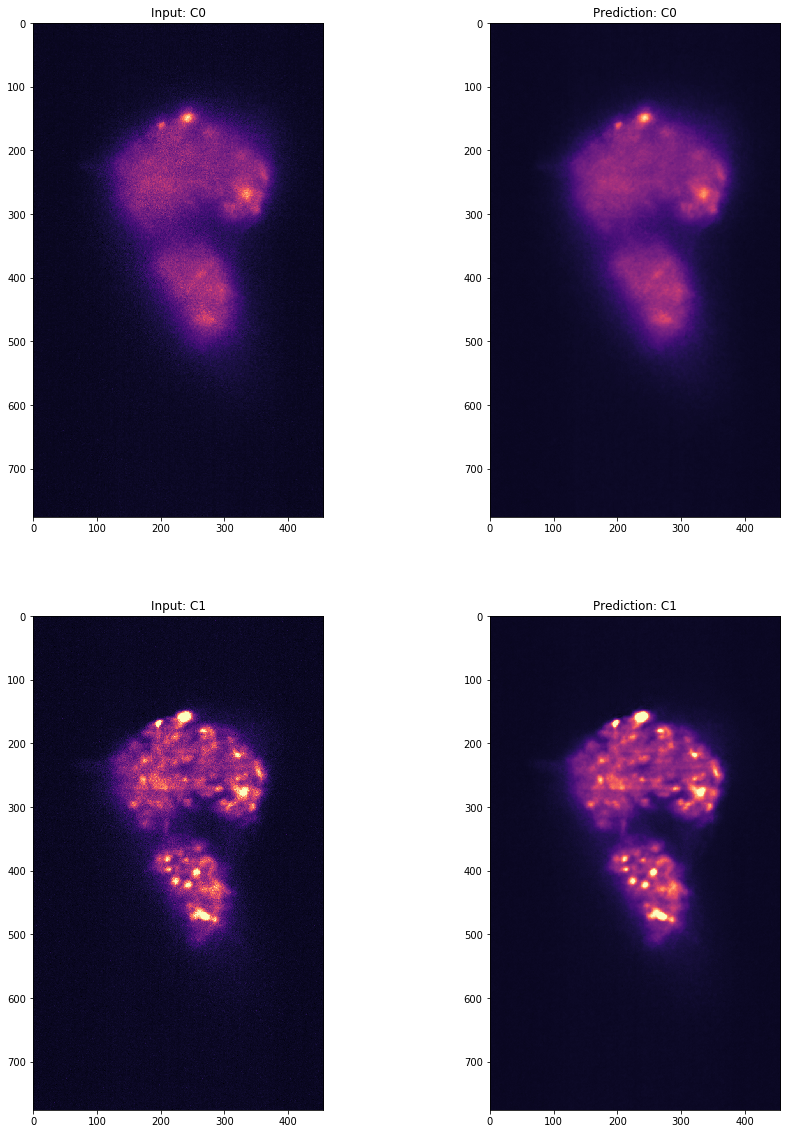

In [36]:
# Let's look at the results.
vmin=np.min(imgs[5][22, ..., 0])
vmax=np.max(imgs[5][22, ..., 0])
plt.figure(figsize=(15,20))
plt.subplot(2,2,1)
plt.imshow(imgs[5][22, ..., 0],cmap="magma", vmin=vmin, vmax=vmax)
plt.title('Input: C0');

plt.subplot(2,2,2)
plt.imshow(pred_train[5][22, ..., 0],cmap="magma", vmin=vmin, vmax=vmax)
plt.title('Prediction: C0');

plt.subplot(2,2,3)
plt.imshow(imgs[5][22, ..., 1],cmap="magma", vmin=vmin, vmax=vmax)
plt.title('Input: C1');

plt.subplot(2,2,4)
plt.imshow(pred_train[5][22, ..., 1],cmap="magma", vmin=vmin, vmax=vmax)
plt.title('Prediction: C1');



## Reconstitute the images

In [30]:
for i in range(10):
    fileindex=390+i
    print(str(fileindex))
    complete=np.concatenate((pred_train[10+i][..., 1], pred_train[i][..., 0]))
    imwrite("/home/lalit/Desktop/04_Data/KellerLabData/04_Denoised/02Sep2019/CM02/"+str(fileindex)+".tif",np.array(complete, dtype='float32'))

390
391
392
393
394
395
396
397
398
399


In [31]:
for i in range(10):
    fileindex=390+i
    print(str(fileindex))
    complete=np.concatenate((pred_train[10+i][..., 0], pred_train[i][..., 1]))
    imwrite("/home/lalit/Desktop/04_Data/KellerLabData/04_Denoised/02Sep2019/CM03/"+str(fileindex)+".tif",np.array(complete, dtype='float32'))

390
391
392
393
394
395
396
397
398
399
